In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

from train_models import ClassifierTrainer

In [2]:
data_path = 'data/Module_6_Lecture_1_CoNLL2003/'

In [3]:
def load_sentences(filepath):
    final = []
    sentences = []
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    return final

In [4]:
train_sents = load_sentences(data_path + 'train.txt')
test_sents = load_sentences(data_path + 'test.txt')
val_sents = load_sentences(data_path + 'valid.txt')

In [5]:
train_sents[:3]

[[('EU', 'B-ORG'),
  ('rejects', 'O'),
  ('German', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('British', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('Peter', 'B-PER'), ('Blackburn', 'I-PER')],
 [('BRUSSELS', 'B-LOC'), ('1996-08-22', 'O')]]

In [6]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
label2id = {value: int(key) for key, value in id2label.items()}

In [7]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}

In [8]:
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)

In [9]:
word_dict = defaultdict(int)

for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

lower_freq_word = []
for k,v in word_dict.items():
    if v < 2:
        lower_freq_word.append(k)

for word in lower_freq_word:
    del word_dict[word]
    
word_dict['<UNK>'] = -1
word_dict['<PAD>'] = -2

word2id = {}

for idx, word in enumerate(word_dict.keys()):
    word2id[word] = idx

In [10]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])

    return idxs

In [11]:
to_check = 102

prepared_data = prepare_sequence(train_df['text'][to_check], word2id)
label = train_df['label'][to_check]
raw_data = train_df['text'][to_check]
too_raw_data = train_sents[to_check]

print(f'Prepared data: {prepared_data}')
print(f'Label: {label}')
print(f'Raw data: {raw_data}')
print(f'Too raw data: {too_raw_data}')

Prepared data: [613, 16, 43, 664, 605, 73, 665, 67, 666, 630, 67, 377, 18, 53, 667, 3, 620, 80, 637, 3, 668, 632, 669, 670, 7]
Label: [5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Raw data: ['Israel', 'on', 'Wednesday', 'sent', 'Syria', 'a', 'message', ',', 'via', 'Washington', ',', 'saying', 'it', 'was', 'committed', 'to', 'peace', 'and', 'wanted', 'to', 'open', 'negotiations', 'without', 'preconditions', '.']
Too raw data: [('Israel', 'B-LOC'), ('on', 'O'), ('Wednesday', 'O'), ('sent', 'O'), ('Syria', 'B-LOC'), ('a', 'O'), ('message', 'O'), (',', 'O'), ('via', 'O'), ('Washington', 'B-LOC'), (',', 'O'), ('saying', 'O'), ('it', 'O'), ('was', 'O'), ('committed', 'O'), ('to', 'O'), ('peace', 'O'), ('and', 'O'), ('wanted', 'O'), ('to', 'O'), ('open', 'O'), ('negotiations', 'O'), ('without', 'O'), ('preconditions', 'O'), ('.', 'O')]


In [12]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        batch_max = max([len(ids) for ids in output["input_ids"]])

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output

In [13]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)#, freeze=True)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)
        
        lstm_output, _ = self.lstm(embeddings) 

        logits = self.fc(lstm_output)
        return logits

In [14]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 50
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)

In [15]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

In [16]:
collate_fn = Collate(True)  

In [17]:
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

In [ ]:
class BiLSTMNERTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) if embeddings is None \
                         else nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)
        self.classifier = nn.Linear(2 * hidden_dim, output_size)

    def forward(self, input_ids, attention_mask=None):
        if input_ids.dtype != torch.long:
            input_ids = input_ids.long()
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        return self.classifier(x)

    
model = BiLSTMNERTagger(
    embedding_dim=100,
    hidden_dim=64,
    vocab_size=VOCAB_SIZE,
    output_size=NUM_CLASSES,
)

In [19]:
parameters = list(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(parameters)

In [ ]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=NUM_CLASSES,
                            device='cpu')

In [21]:
trainer.fit(train_loader,
            val_loader,
            num_epoch=10,
            info_every_iter=1,
            show_val_metrics=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 0.7824 Acc: 0.1204 Rec: 0.1204 Prec: 0.2695
Epoch [2/10] Train Loss: 0.3808 Acc: 0.4107 Rec: 0.4107 Prec: 0.5802
Epoch [3/10] Train Loss: 0.2084 Acc: 0.6465 Rec: 0.6465 Prec: 0.7329
Epoch [4/10] Train Loss: 0.1277 Acc: 0.7792 Rec: 0.7792 Prec: 0.8324
Epoch [5/10] Train Loss: 0.0824 Acc: 0.8587 Rec: 0.8587 Prec: 0.8945
Epoch [6/10] Train Loss: 0.0562 Acc: 0.9084 Rec: 0.9084 Prec: 0.9333
Epoch [7/10] Train Loss: 0.0402 Acc: 0.9358 Rec: 0.9358 Prec: 0.9522
Epoch [8/10] Train Loss: 0.0291 Acc: 0.9553 Rec: 0.9553 Prec: 0.9674
Epoch [9/10] Train Loss: 0.0253 Acc: 0.9651 Rec: 0.9651 Prec: 0.9731
Epoch [10/10] Train Loss: 0.0185 Acc: 0.9735 Rec: 0.9735 Prec: 0.9803


In [22]:
def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

def test(model, data, labels, target_names): 
    predictions, correct = [], []
    
    model.eval()
    with torch.no_grad():    
        for batch in data:
            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to('cpu')).view(cur_batch_size*text_length, NUM_CLASSES)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

            predictions += predicted_labels
            correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [23]:
labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(model, test_loader, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

       B-PER       0.86      0.67      0.76      1617
       I-PER       0.89      0.78      0.83      1156
       B-ORG       0.83      0.63      0.71      1661
       I-ORG       0.82      0.72      0.77       835
       B-LOC       0.90      0.76      0.82      1668
       I-LOC       0.78      0.63      0.70       257
      B-MISC       0.79      0.65      0.72       702
      I-MISC       0.75      0.60      0.67       216

   micro avg       0.85      0.70      0.77      8112
   macro avg       0.83      0.68      0.75      8112
weighted avg       0.85      0.70      0.77      8112



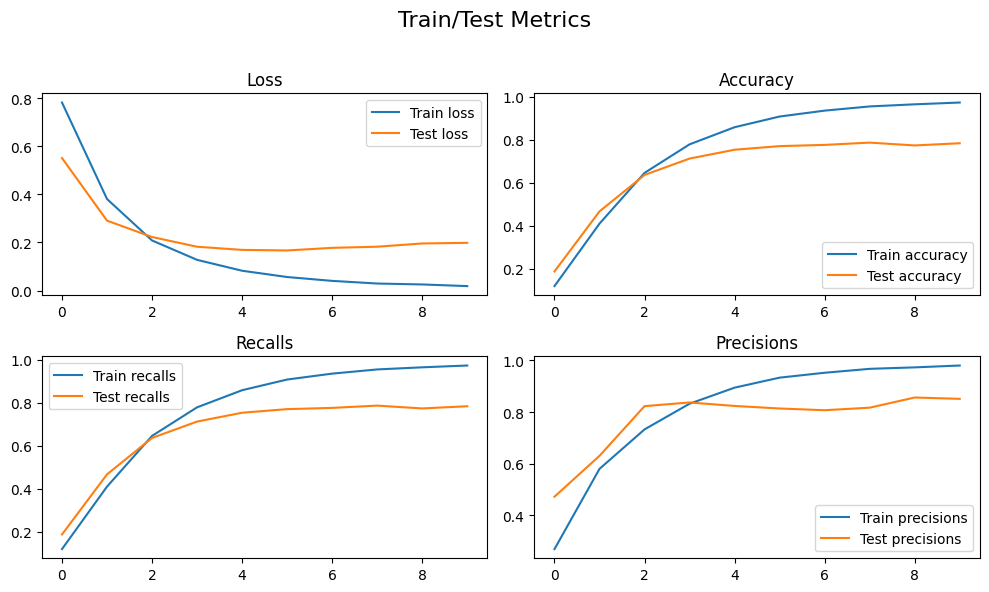

In [24]:
trainer.plot_metrics()